# 1. Install Dependencies and Setup

In [188]:
#!pip install tensorflow tensorflow opencv-python matplotlib

In [189]:
#!pip list

In [190]:
import tensorflow as tf
from tensorflow import keras
import os

In [191]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [192]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [193]:
import cv2
import imghdr

In [194]:
data_dir = 'data_cars'

In [195]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [196]:
num_obs = [0,0]
class_idx = -1
for image_class in os.listdir(data_dir):
    class_idx = class_idx + 1
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
            else:
                num_obs[class_idx] = num_obs[class_idx] + 1
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [197]:
import numpy as np
from matplotlib import pyplot as plt

In [198]:
# build data from directories of images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 930 files belonging to 2 classes.


In [199]:
class_names = data.class_names
print(class_names)

['ferrari', 'minivan']


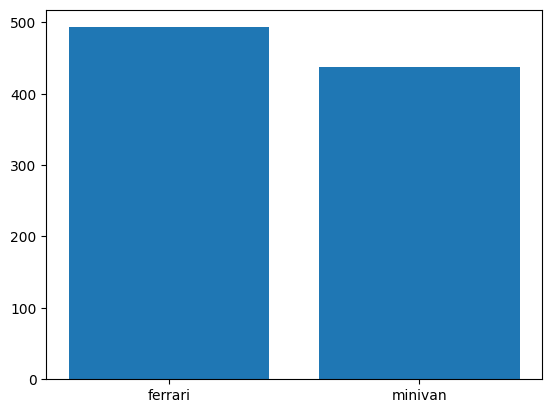

In [200]:
plt.bar([class_names[0],class_names[1]], num_obs);

In [201]:
data_iterator = data.as_numpy_iterator()

In [202]:
batch = data_iterator.next()

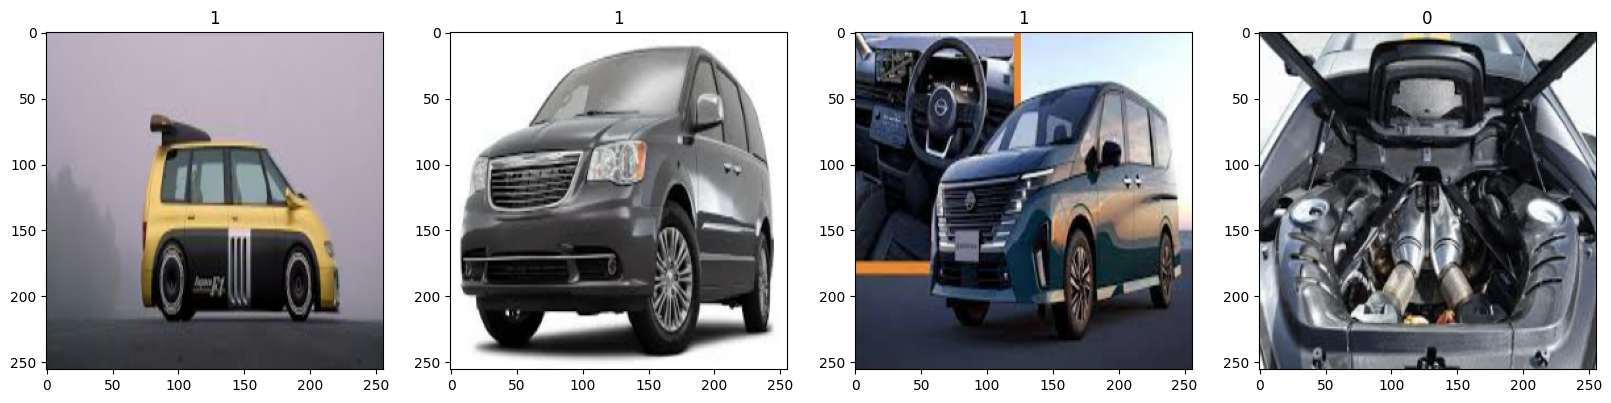

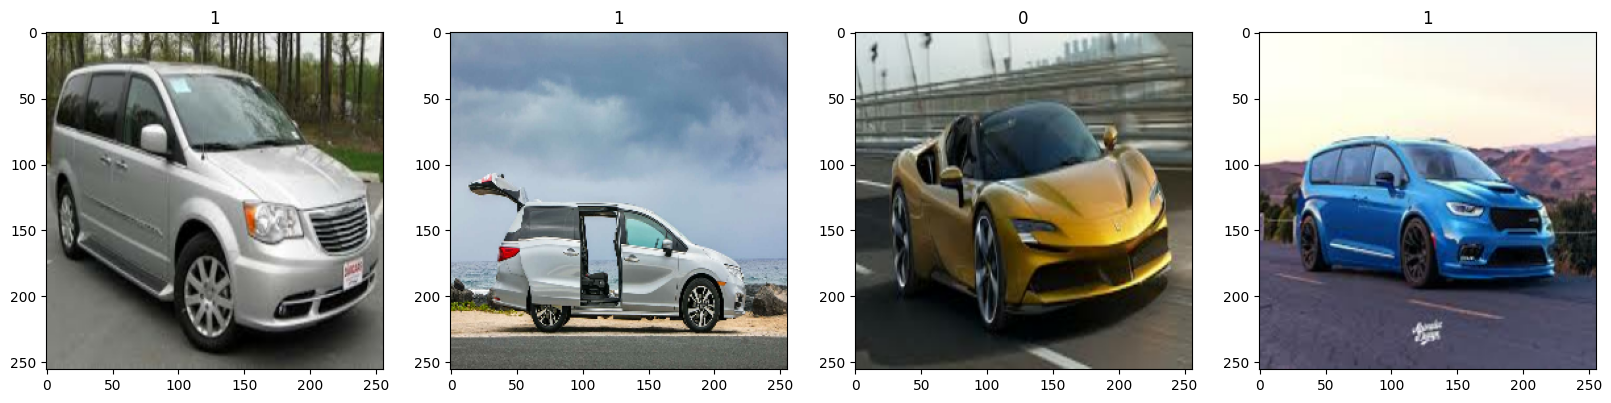

In [203]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][4:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][4+idx])

# 4. Scale Data

In [204]:
data = data.map(lambda x,y: (x/255, y))

In [205]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

# 5. Split Data

In [206]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [207]:
train_size

21

In [208]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [209]:
n_epochs = 8

In [210]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [211]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [212]:
model = Sequential()

In [213]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [214]:
model.compile('adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [215]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

# 7. Train

In [216]:
logdir='logs'

In [217]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [218]:
hist = model.fit(train, epochs=n_epochs, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
21/21 [==============================] - 20s 832ms/step - loss: 0.7497 - accuracy: 0.6652 - precision_8: 0.6534 - recall_8: 0.6554 - val_loss: 0.4794 - val_accuracy: 0.7656 - val_precision_8: 0.6870 - val_recall_8: 0.8977
Epoch 2/8
21/21 [==============================] - 19s 856ms/step - loss: 0.4667 - accuracy: 0.7842 - precision_8: 0.7098 - recall_8: 0.9180 - val_loss: 0.4517 - val_accuracy: 0.7708 - val_precision_8: 0.7130 - val_recall_8: 0.8817
Epoch 3/8
21/21 [==============================] - 18s 809ms/step - loss: 0.4125 - accuracy: 0.7991 - precision_8: 0.7308 - recall_8: 0.9048 - val_loss: 0.3440 - val_accuracy: 0.8594 - val_precision_8: 0.7736 - val_recall_8: 0.9647
Epoch 4/8
21/21 [==============================] - 18s 793ms/step - loss: 0.3921 - accuracy: 0.8110 - precision_8: 0.7462 - recall_8: 0.9195 - val_loss: 0.3692 - val_accuracy: 0.8438 - val_precision_8: 0.7850 - val_recall_8: 0.9231
Epoch 5/8
21/21 [==============================] - 19s 846ms/step - loss

# 8. Plot Performance

In [219]:
 def plot_metrics(history, class_names):
    # percision = fraction of predicted 'trues' that are correct
    # recall = fraction of 'trues' that were found
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
    ls = ['-','--','.']
    j = 0
    for hist in history:
        metric_names = list(hist.history.keys())
        for idx in range(2):
            ax[0,idx].plot(hist.history[metric_names[idx]], color='teal', linestyle=ls[j], label=metric_names[idx])
            ax[0,idx].plot(hist.history['val_'+metric_names[idx]], color='orange', linestyle=ls[j], label='val_'+metric_names[idx])
            ax[0,idx].set_title(metric_names[idx], fontsize=10)
            ax[0,idx].legend()
        for idx in range(2):
            ax[1,idx].plot(hist.history[metric_names[idx+2]], color='teal', linestyle=ls[j], label=metric_names[idx+2])
            ax[1,idx].plot(hist.history['val_'+metric_names[idx+2]], color='orange', linestyle=ls[j], label='val_'+metric_names[idx+2])
            ax[1,idx].set_title(metric_names[idx+2], fontsize=10)
            ax[1,idx].legend()
        j = j + 1
    fig.suptitle('Evaluation Metrics - '+class_names[0]+' vs '+class_names[1], fontsize=20)

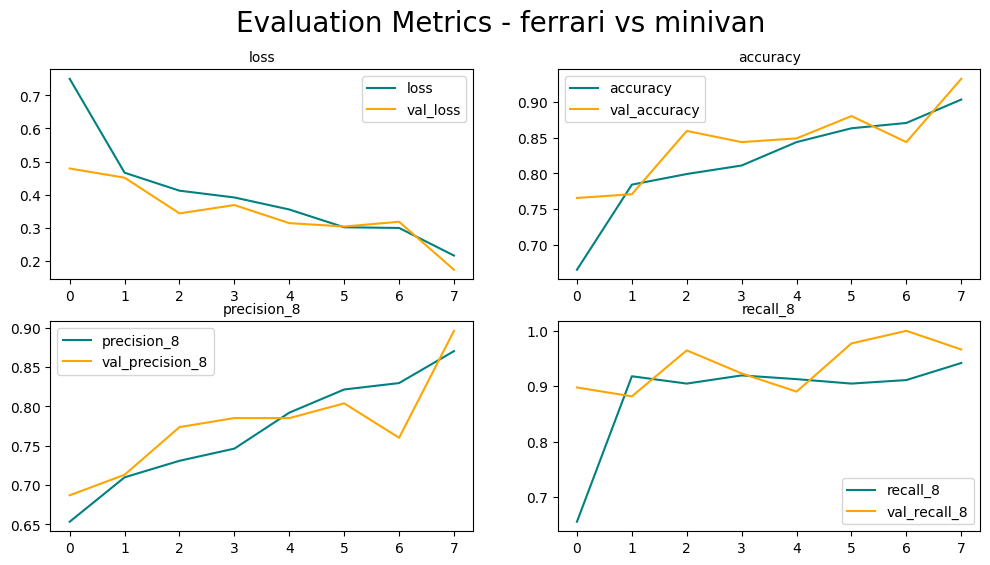

In [220]:
plot_metrics([hist], class_names)

In [221]:
# save the history from validating this model for future comparison
base_model_hist = hist

# 9. Evaluate

In [222]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [223]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [224]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 103ms/step


In [225]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8666667, shape=(), dtype=float32) tf.Tensor(0.9285714, shape=(), dtype=float32) tf.Tensor(0.90909094, shape=(), dtype=float32)


# 10. Test

In [226]:
import cv2

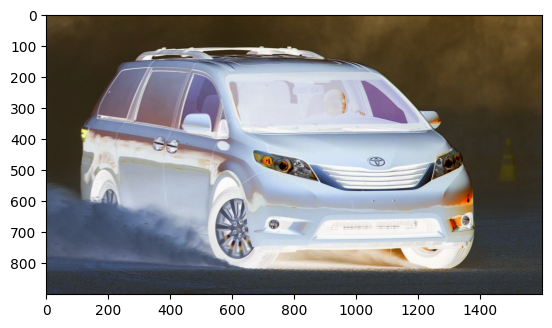

In [227]:
img = 255-cv2.imread(data_dir+'/minivan/2015-toyota-sienna-front-right.jpg')
#img = cv2.cvtColor(255-img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

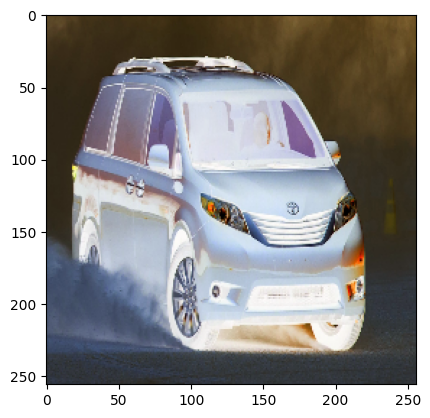

In [228]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [229]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 35ms/step


In [230]:
print(yhat)

[[0.9324623]]


In [231]:
if yhat > 0.5: 
    print(f'Predicted class is Minivan')
else:
    print(f'Predicted class is Ferrari')

Predicted class is Minivan


# 11. Save the Model

In [232]:
from tensorflow.keras.models import load_model

In [233]:
mode_fname = os.path.join('models','imageclassifier.h5')
model.save(mode_fname)

In [234]:
new_model = load_model(mode_fname)

In [235]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 101ms/step


array([[0.9324623]], dtype=float32)

# Regularization

In [236]:
model = Sequential()
# see: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
# see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2
model.add(Conv2D(16, (3,3), 1, activation='elu', input_shape=(256,256,3),
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='elu',
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='elu',
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="nadam",
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
# loss="sparse_categorical_crossentropy"
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
hist = model.fit(train, epochs=n_epochs, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
21/21 [==============================] - 23s 923ms/step - loss: 2.8853 - accuracy: 0.6890 - precision_10: 0.6734 - recall_10: 0.7082 - val_loss: 1.7188 - val_accuracy: 0.8125 - val_precision_10: 0.7812 - val_recall_10: 0.8333
Epoch 2/8
21/21 [==============================] - 20s 881ms/step - loss: 1.7232 - accuracy: 0.7857 - precision_10: 0.7500 - recall_10: 0.8208 - val_loss: 1.6310 - val_accuracy: 0.8177 - val_precision_10: 0.7629 - val_recall_10: 0.8605
Epoch 3/8
21/21 [==============================] - 20s 886ms/step - loss: 1.5976 - accuracy: 0.8274 - precision_10: 0.7913 - recall_10: 0.8612 - val_loss: 1.5416 - val_accuracy: 0.8698 - val_precision_10: 0.9125 - val_recall_10: 0.8022
Epoch 4/8
21/21 [==============================] - 19s 859ms/step - loss: 1.4877 - accuracy: 0.8869 - precision_10: 0.8680 - recall_10: 0.9052 - val_loss: 1.4323 - val_accuracy: 0.9167 - val_precision_10: 0.8526 - val_recall_10: 0.9759
Epoch 5/8
21/21 [==============================] - 21s 9

In [ ]:
plot_metrics([base_model_hist, hist], class_names)

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

# Test the regularized model

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())